## Fetching data from HITRAN with `HAPI`

Here we show how to programmatically fetch data from HITRAN.

You can get HAPI online: 

https://hitran.org/hapi/

In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
import hapi

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


You can fetch a portion of a [HITRAN linelist](https://hitran.org/lbl/) by providing the species, isotope, and wavenumber limits.  Let's restrict to the HPF bandwidth.

In [3]:
wl_limits = np.array([810, 1280])*u.nm
wavenum_limits = wl_limits.to(u.cm**-1, equivalencies=u.spectral())
hi, lo = wavenum_limits.round().value.astype(int).tolist()

We'll select `OH`, which is the 13$^{th}$ species in the [HITRAN list](https://hitran.org/lbl/).  We choose the predominant (1) isotopologue.

In [4]:
hapi.fetch('OH', 13, 1, lo, hi)


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: OH
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
  65536 bytes written to ./OH.data
Header written to ./OH.header
END DOWNLOAD
                     Lines parsed: 6490
PROCESSED


You can download more species following the HITRAN list.

In [5]:
#%%capture
#hapi.fetch('N2', 22, 1, lo, hi)
#hapi.fetch('O2', 7, 1, lo, hi)
#hapi.fetch('H2O', 1, 1, lo, hi)
#hapi.fetch('CO2', 2, 1, lo, hi)

The data is stored locally:

In [6]:
! mkdir temp_data 

mkdir: cannot create directory ‘temp_data’: File exists


In [7]:
! mv *.data temp_data/
! mv *.header temp_data/

Let's load it into memory:

In [8]:
hapi.db_begin('./temp_data/')

Using ./temp_data/

OH
                     Lines parsed: 6490


The table has the pressure broadening coefficients for Lorentzian line profiles for each spectral line:

$$ f_{L}(\nu; \nu_{ij}, T, p) = \frac{1}{\pi}\frac{\gamma(p, T)}{\gamma(p,T)^2, + [\nu-(\nu_{ij}+\delta(p_{ref})p)]^2}$$

In [9]:
hapi.describeTable('OH')

-----------------------------------------
OH summary:
-----------------------------------------
Number of rows: 6490
Table type: column-fixed
-----------------------------------------
            PAR_NAME           PAR_FORMAT

            molec_id                  %2d
        local_iso_id                  %1d
                  nu               %12.6f
                  sw               %10.3E
                   a               %10.3E
           gamma_air                %5.4f
          gamma_self                %5.3f
              elower               %10.4f
               n_air                %4.2f
           delta_air                %8.6f
 global_upper_quanta                 %15s
 global_lower_quanta                 %15s
  local_upper_quanta                 %15s
  local_lower_quanta                 %15s
                ierr                  %6s
                iref                 %12s
    line_mixing_flag                  %1s
                  gp                %7.1f
                 

We need to provide a wavenumber grid, and a dictionary describing the atmospheric conditions.

In [10]:
nus = np.linspace(lo, hi, 20000)
wls = (nus*u.cm**-1).to(u.nm, equivalencies=u.spectral())
environment_dict = {'T':296.0, 'p':1.0} 

In [11]:
nu, coeffs = hapi.absorptionCoefficient_Lorentz(SourceTables='OH', WavenumberGrid=nus.tolist(), 
                                                Diluent={'air':1.0},HITRAN_units=False,
                                                Environment=environment_dict)

{'air': 1.0}


Those are the absorption coefficients.  We want to compute the emission spectrum of OH using these coefficients, which requires the path length assuming a fixed atmospheric density.  Let's say 8km, roughly the Earth's atmosphere's scale height; HAPI expects units in cm.

In [12]:
path_length = (8.0*u.km).to(u.cm).value

In [13]:
nu, emission = hapi.radianceSpectrum(nu, coeffs, Environment={'l':path_length, **environment_dict})

Let's plot the emission spectrum of OH over the HPF wavelength range:

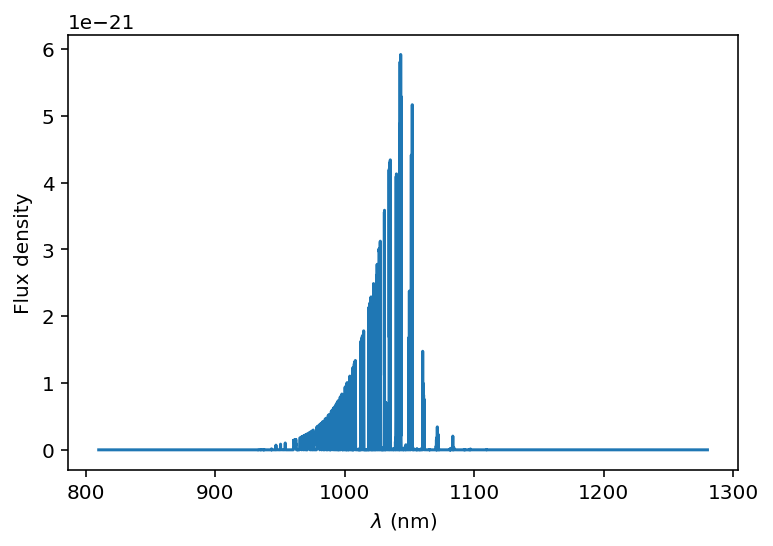

In [14]:
plt.plot(wls, emission, label='OH lines'); plt.xlabel('$\lambda$ (nm)'); plt.ylabel('Flux density');

It looks like some of the energy levels max out at the Planck function. 

In [15]:
from astropy.modeling import models
bb = models.BlackBody(temperature=296*u.K)
bb_296 = bb(wls)  

In [16]:
mask = (wls.value > 950) & (wls.value < 1100)
bb_scaled = bb_296.value / np.median(bb_296.value[mask])*1e-21

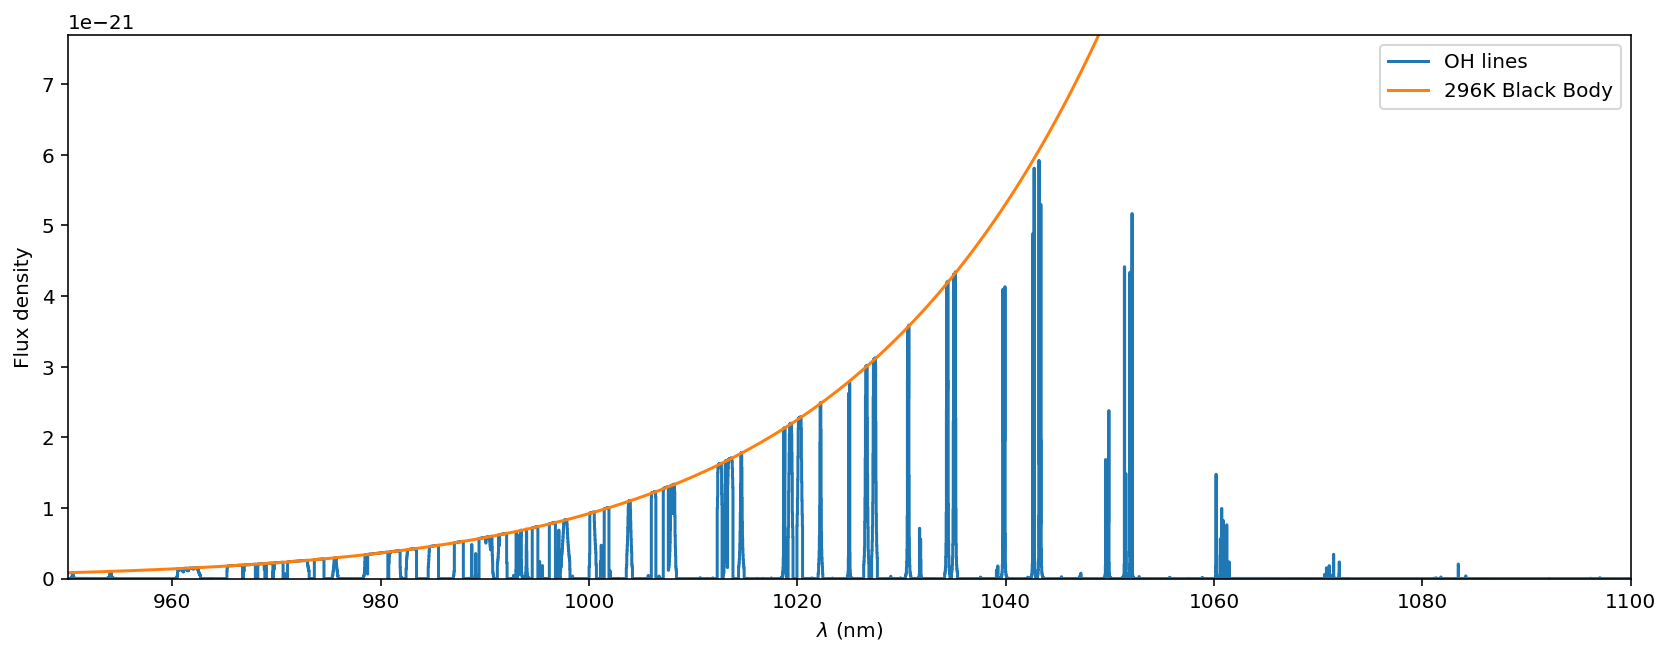

In [17]:
plt.figure(figsize=(14, 5))
plt.step(wls, emission, label='OH lines'); plt.xlabel('$\lambda$ (nm)'); plt.ylabel('Flux density');
plt.plot(wls, bb_scaled*2.2, label='296K Black Body')
plt.xlim(950, 1100);
plt.ylim(0, emission.max()*1.3); plt.legend(loc='best');

 I suspect this conspicuous appearance is artificially emphasized in this one-layer demo.  In real life spectra the emergent spectra consist of many layers of different temperatures, pressures, and line profiles, blurring out the OH lines.